In [58]:
noisy = False

In [59]:
from qiskit_aer.noise import NoiseModel
from qiskit.providers.fake_provider import FakeVigo

# fake providers contain data from real IBM Quantum devices stored in Qiskit Terra,
# and are useful for extracting realistic noise models.
device = FakeVigo()

coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)

print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['cx', 'sx', 'x', 'id', 'measure']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('cx', (3, 4)), ('cx', (4, 3)), ('cx', (3, 1)), ('cx', (1, 3)), ('cx', (1, 2)), ('cx', (2, 1)), ('cx', (0, 1)), ('cx', (1, 0)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('measure', (4,))]


In [60]:
from qiskit.utils import algorithm_globals
from qiskit_aer.primitives import Estimator as AerEstimator

seed = 170
algorithm_globals.random_seed = seed

if noisy:
    bo = {
        "method": "density_matrix",
        "coupling_map": coupling_map,
        "noise_model": noise_model,
    }
else:
    bo = {}

noisy_estimator = AerEstimator(
    backend_options=bo,
    run_options={"seed": seed, "shots": 1024},
    transpile_options={"seed_transpiler": seed},
)

In [61]:
data = {
    'ec': [],#Evaluation count
    'pm': [],#Parameters
    'em': [],#Elavuated mean
    'es': [],#Evaluated Standard Deviation
    'ef': [],#Entropy of Formation
    'pr': [],#Purity
    'en': [],#Entropy
    'se': [],#Shanon Entropy
    'cc': [] #concurences
}

def store_intermediate_result(eval_count, parameters, mean, std):
    data['ec'].append(eval_count)
    data['pm'].append(parameters)
    data['em'].append(mean)
    data['es'].append(std)


In [62]:
from qiskit.quantum_info import SparsePauliOp

H2_op = SparsePauliOp.from_list(
    [
        ("II", -1.052373245772859),
        ("IZ", 0.39793742484318045),
        ("ZI", -0.39793742484318045),
        ("ZZ", -0.01128010425623538),
        ("XX", 0.18093119978423156),
    ]
)

print(f"Number of qubits: {H2_op.num_qubits}")

Number of qubits: 2


In [63]:
# define ansatz and optimizer
from qiskit.circuit.library import TwoLocal
from qiskit.algorithms.optimizers import SPSA

iterations = 125
ansatz = TwoLocal(rotation_blocks="ry", entanglement_blocks="cz")
spsa = SPSA(maxiter=iterations)

In [64]:
from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit.opflow import PauliSumOp

numpy_solver = NumPyMinimumEigensolver()
result = numpy_solver.compute_minimum_eigenvalue(operator=PauliSumOp(H2_op))
ref_value = result.eigenvalue.real
print(f"Reference value: {ref_value:.5f}")

Reference value: -1.85728


C:\Users\saxen\AppData\Local\Temp\ipykernel_25128\1936825166.py:4: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.numpy_minimum_eigen_solver.NumPyMinimumEigensolver`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.NumPyMinimumEigensolver``. See https://qisk.it/algo_migration for a migration guide.
  numpy_solver = NumPyMinimumEigensolver()
C:\Users\saxen\AppData\Local\Temp\ipykernel_25128\1936825166.py:5: DeprecationWarning: The class ``qiskit.opflow.primitive_ops.pauli_sum_op.PauliSumOp`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  result = numpy_solver.compute_minimum_eigenvalue(operator=PauliSumOp(H2_op))


In [65]:
# instantiate and run VQE
from qiskit.algorithms.minimum_eigensolvers import VQE

vqe = VQE(
   noisy_estimator, ansatz, optimizer=spsa, callback=store_intermediate_result
)
result = vqe.compute_minimum_eigenvalue(operator=H2_op)

print(f"VQE on Aer qasm simulator: {result.eigenvalue.real:.5f}")
print(
    f"Delta from reference energy value is {(result.eigenvalue.real - ref_value):.5f}"
)

VQE on Aer qasm simulator(with noise): -1.85160
Delta from reference energy value is 0.00567


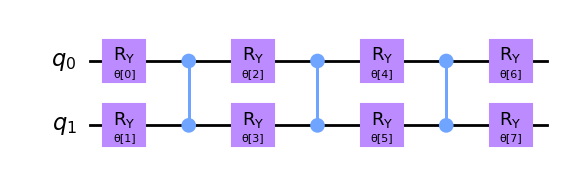

In [66]:
circq = result.optimal_circuit
display(circq.decompose().draw(output='mpl'))

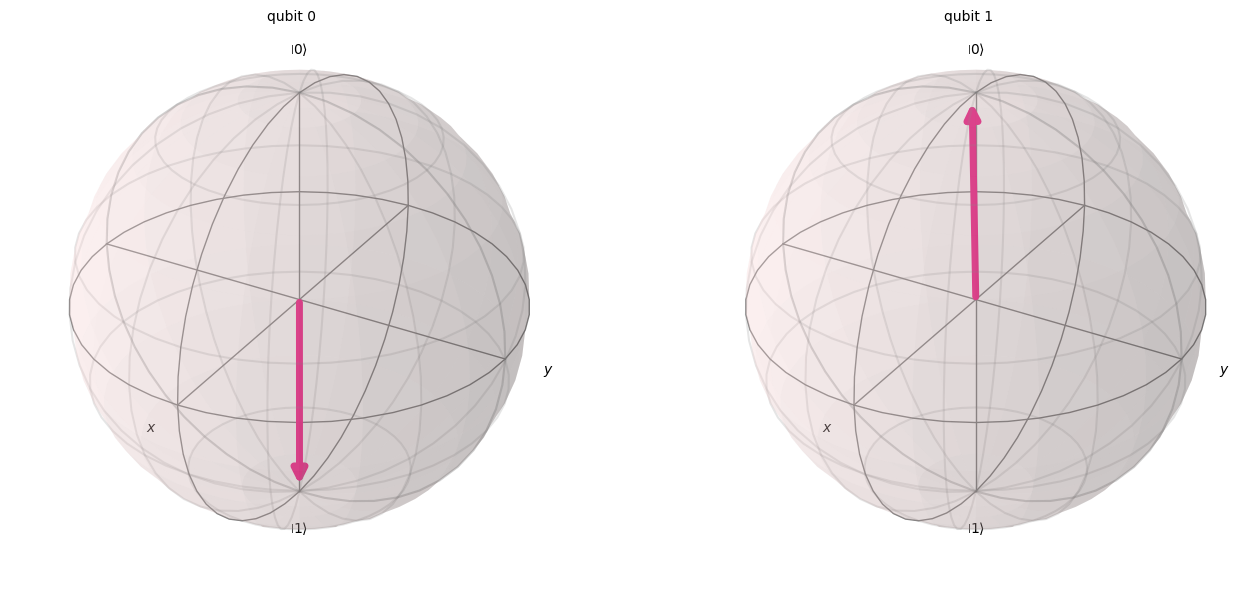

In [67]:
bounz_ansatz = ansatz.bind_parameters(result.optimal_parameters)
from qiskit.visualization import plot_bloch_multivector
from qiskit.quantum_info import Statevector
quantum_state = Statevector.from_instruction(bounz_ansatz)
plot_bloch_multivector(quantum_state)

In [68]:
from qiskit.quantum_info import Statevector, concurrence
from qiskit.quantum_info import entanglement_of_formation, entropy, shannon_entropy, purity
for j in data['pm']:
    bound_ansatz = ansatz.bind_parameters(j)
    i = Statevector.from_instruction(bound_ansatz)
    data['ef'].append(entanglement_of_formation(i))
    data['en'].append(entropy(i))
    data['pr'].append(purity(i))
    data['se'].append(shannon_entropy(i))
    data['cc'].append(concurrence(i))

[Text(0.5, 0, 'Evaluation Count'), Text(0, 0.5, 'Standard Deviation')]

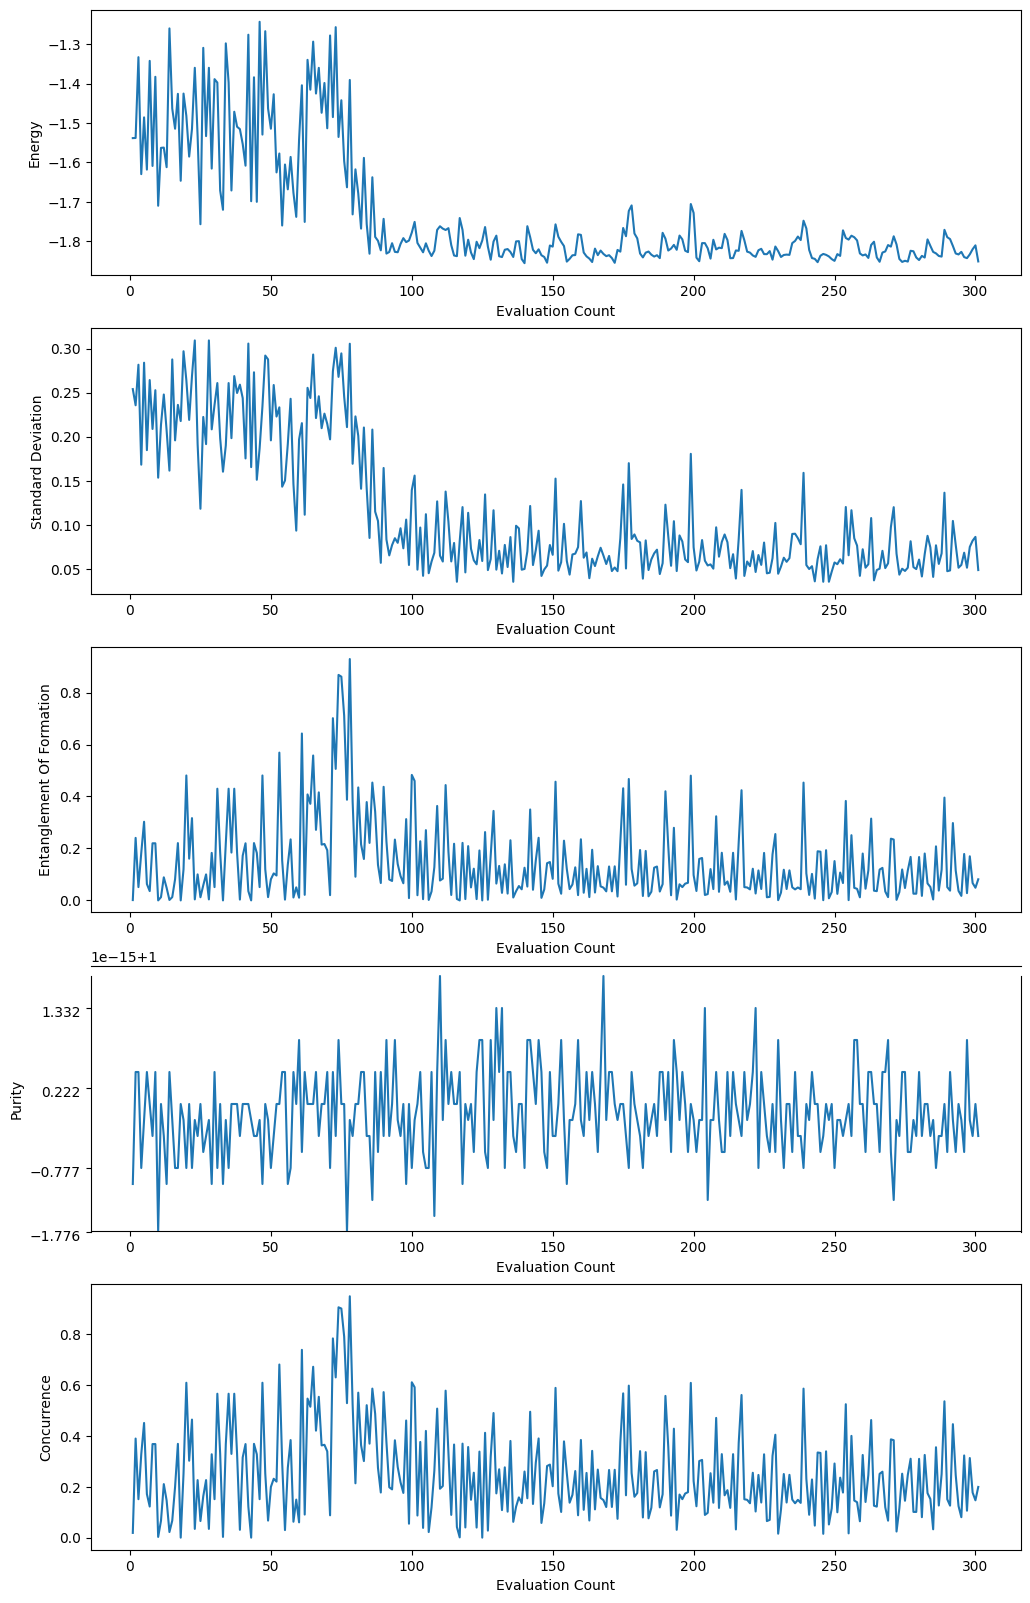

In [69]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, (a,b,x,y,z) = plt.subplots(5, figsize=(12, 20))


x.plot(data['ec'], data['ef'])
x.set(xlabel='Evaluation Count', ylabel='Entanglement Of Formation')



import numpy as np

stp = 0.000000000000001
ul = max(data['pr']) #1.0000000000000018
ll = min(data['pr'])#0.9999999999999998

y.plot(data['ec'],data['pr'])
y.set(xlabel='Evaluation Count', ylabel='Purity', yticks = np.arange(ll, ul, step=stp), ylim = [ll, ul])




z.plot(data['ec'], data['cc'])
z.set(xlabel='Evaluation Count', ylabel='Concurrence')




a.plot(data['ec'], data['em'])
a.set(xlabel='Evaluation Count', ylabel='Energy')




b.plot(data['ec'], [i['variance'] for i in data['es']])
b.set(xlabel='Evaluation Count', ylabel='Standard Deviation')